<a href="https://colab.research.google.com/github/mahmoudamr25/fraud_detection_project/blob/main/ML_P2_M1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")

In [17]:
#load Train Data
beneficiary_df = pd.read_csv("/content/Train_Beneficiarydata-1542865627584.csv")
inpatient_df   = pd.read_csv("/content/Train_Inpatientdata-1542865627584.csv")
outpatient_df  = pd.read_csv("/content/Train_Outpatientdata-1542865627584.csv")
labels_df      = pd.read_csv("/content/Train-1542865627584.csv")

In [18]:
#Structure Overview
beneficiary_df.info()
inpatient_df.info()
outpatient_df.info()
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [19]:
#Missing Value Summary
def missing(df, name):
    print("\n--- Missing in", name, "---")
    print(df.isna().sum().sort_values(ascending=False).head(20))

missing(beneficiary_df, "Beneficiary")
missing(inpatient_df, "Inpatient")
missing(outpatient_df, "Outpatient")
missing(labels_df, "Labels")


--- Missing in Beneficiary ---
DOD                                137135
BeneID                                  0
DOB                                     0
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
dtype: int64

--- Missing in Inpatient ---
ClmProcedureCode_6     40474
ClmProcedureCode_5     40465
ClmProcedureCode_4     4035

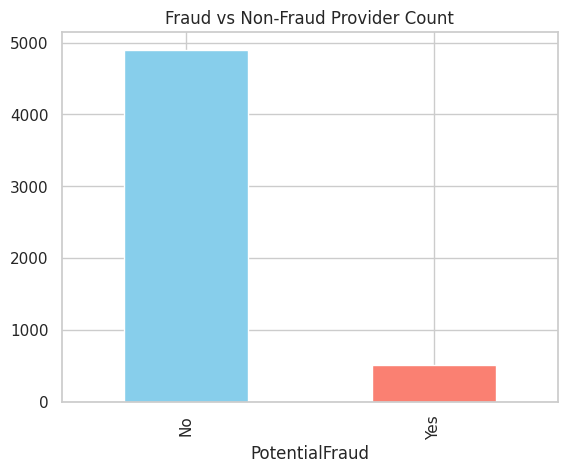

,proportion
PotentialFraud,
No,90.64695
Yes,9.35305


In [20]:
#Fraud Label Distribution
labels_df["PotentialFraud"].value_counts().plot(kind="bar", color=["skyblue","salmon"])
plt.title("Fraud vs Non-Fraud Provider Count")
plt.show()

labels_df["PotentialFraud"].value_counts(normalize=True)*100

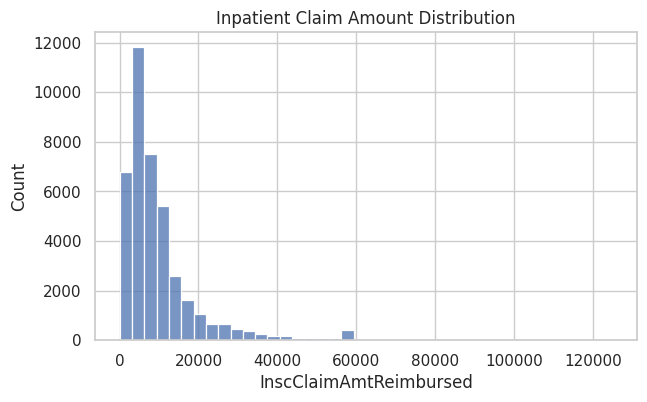

In [21]:
#Inpatient EDA
plt.figure(figsize=(7,4))
sns.histplot(inpatient_df["InscClaimAmtReimbursed"], bins=40)
plt.title("Inpatient Claim Amount Distribution")
plt.show()


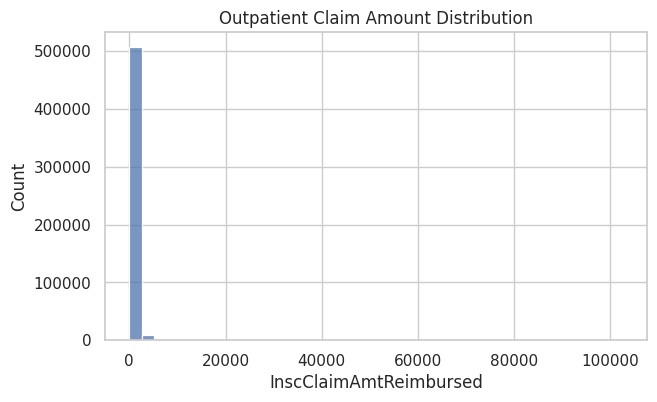

In [22]:
#Outpatient EDA
plt.figure(figsize=(7,4))
sns.histplot(outpatient_df["InscClaimAmtReimbursed"], bins=40)
plt.title("Outpatient Claim Amount Distribution")
plt.show()

In [23]:
#Fraud Comparison
inpatient_labeled = inpatient_df.merge(labels_df, on="Provider", how="left")

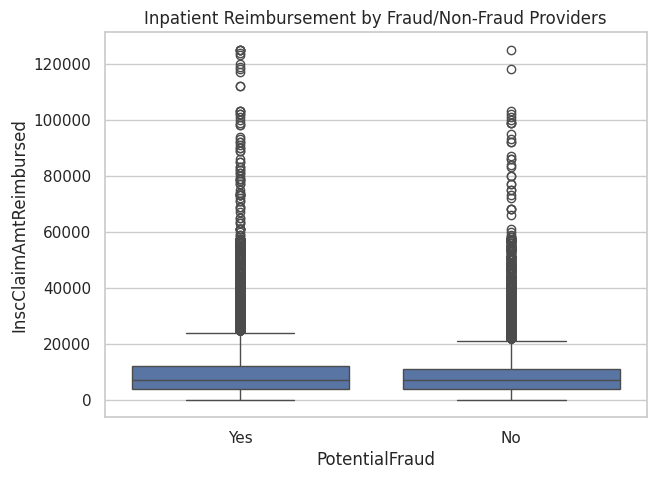

In [24]:
#Boxplot Comparing reimbursement by fraud
plt.figure(figsize=(7,5))
sns.boxplot(
    data=inpatient_labeled,
    x="PotentialFraud",
    y="InscClaimAmtReimbursed"
)
plt.title("Inpatient Reimbursement by Fraud/Non-Fraud Providers")
plt.show()

In [25]:
#PROVIDER-LEVEL AGGREGATION
#Inpatient provider-level features
inpatient_agg = inpatient_df.groupby("Provider").agg(
    ip_num_claims=("ClaimID","count"),
    ip_total_reimbursed=("InscClaimAmtReimbursed","sum"),
    ip_mean_reimbursed=("InscClaimAmtReimbursed","mean"),
    ip_unique_bene=("BeneID","nunique"),
    ip_total_deductible=("DeductibleAmtPaid","sum")
).reset_index()

In [26]:
#Outpatient provider-level features
outpatient_agg = outpatient_df.groupby("Provider").agg(
    op_num_claims=("ClaimID","count"),
    op_total_reimbursed=("InscClaimAmtReimbursed","sum"),
    op_mean_reimbursed=("InscClaimAmtReimbursed","mean"),
    op_unique_bene=("BeneID","nunique"),
    op_total_deductible=("DeductibleAmtPaid","sum")
).reset_index()

In [27]:
#Beneficiary → Provider mapping
ip_pairs = inpatient_df[["Provider","BeneID"]].drop_duplicates()
op_pairs = outpatient_df[["Provider","BeneID"]].drop_duplicates()

provider_bene = pd.concat([ip_pairs, op_pairs]).drop_duplicates()
provider_bene = provider_bene.merge(beneficiary_df, on="BeneID", how="left")

In [29]:
#Aggregate beneficiary characteristics per provider
chronic_cols = [col for col in beneficiary_df.columns if col.startswith("ChronicCond")]
chronic_cols


['ChronicCond_Alzheimer',
 'ChronicCond_Heartfailure',
 'ChronicCond_KidneyDisease',
 'ChronicCond_Cancer',
 'ChronicCond_ObstrPulmonary',
 'ChronicCond_Depression',
 'ChronicCond_Diabetes',
 'ChronicCond_IschemicHeart',
 'ChronicCond_Osteoporasis',
 'ChronicCond_rheumatoidarthritis',
 'ChronicCond_stroke']

In [32]:
bene_agg = provider_bene.groupby("Provider").agg(
    avg_bene_age=("DOB", lambda x:
                  (pd.to_datetime("2025-01-01") - pd.to_datetime(x, errors="coerce"))
                  .dt.days.mean() / 365),
    num_unique_bene=("BeneID", "nunique"),
    **{f"pct_{col}": (col, "mean") for col in chronic_cols}
).reset_index()


In [37]:
#Creating provider_df
provider_df = labels_df.copy()

provider_df = (
    provider_df
    .merge(inpatient_agg, on="Provider", how="left")
    .merge(outpatient_agg, on="Provider", how="left")
    .merge(bene_agg, on="Provider", how="left")
)

In [38]:
provider_df.head()
provider_df.shape

(5410, 25)

In [39]:
# fill missing numeric values
num_cols = provider_df.select_dtypes(include=[np.number]).columns
provider_df[num_cols] = provider_df[num_cols].fillna(0)

In [41]:
#Saving Final Provider level Dataset
provider_df.to_csv("/content/provider_level_train.csv", index=False)
